In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, KBinsDiscretizer, power_transform
from sklearn.metrics import accuracy_score

## Data Exploration / Preprocessing

In [7]:
raw_data = pd.read_csv("train.csv", header = 0, encoding ='utf-8')
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
raw_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
#find which columns have null values
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<AxesSubplot:>

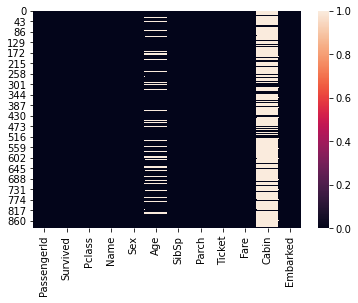

In [6]:
sns.heatmap(raw_data.isnull())

In [7]:
#38% survived
raw_data['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [8]:
#female survival much higher
raw_data.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

<AxesSubplot:xlabel='Survived', ylabel='Age'>

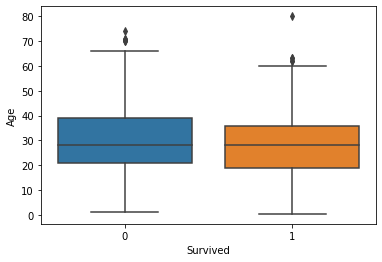

In [9]:
#Notable outliers for age
sns.boxplot(x=raw_data['Survived'], y=raw_data['Age'])

In [10]:
# Survivals by class... 1 and 2 had better chance
pd.pivot_table(raw_data, index='Survived', columns='Pclass', values='PassengerId', aggfunc='count')

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [8]:
#remove (most likely) irrelevant columns - Name, Ticket
#leaving Fare and Embarked for now... I don't think they're relevant but they could be.

data = raw_data[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']]
y = data[['Survived']]

In [17]:
# *there are 2 instances where embarked is NaN, so lets just remove those
new_data = data[data['Embarked'].notna()].copy()
new_data

#encode gender
sex_mapping = {
    'female': 0,
    'male': 1
}
new_data['Sex'].replace(sex_mapping, inplace=True)

#encode embarked
embarked_mapping = {
    'C': 0,
    'Q': 1,
    'S': 2
}
new_data['Embarked'].replace(embarked_mapping, inplace=True)

X = new_data[['Pclass','Sex','SibSp','Parch','Fare','Embarked']].copy()
y = new_data['Survived'].copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,)

## Random Forests Model

In [178]:
# Baseline random forest classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.797752808988764

In [179]:
#Hyperparameter tuning - using lots of parameters here to see how much this can vary
cv = KFold(n_splits=10, shuffle=True)
param_grids = {
    "n_estimators": [5, 10, 20, 50, 100],
    "max_depth": [3, 5, 10, 20],
    "min_samples_leaf": [1, 2, 3, 4],
    "max_features": [4, 5, 6],
    "max_samples": [50, 100, 300, 500, 711]
}
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grids,
    cv=cv,
    ).fit(X, y)
results = pd.DataFrame(grid_search.cv_results_)

In [180]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=10, max_features=6, max_samples=500,
                       min_samples_leaf=3, n_estimators=50, random_state=0)

In [181]:
#there was a little improvement with a lot of parameter tuning. Let's do some feature engineering and play around with different models.
results.loc[results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_samples,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
873,0.061545,0.003431,0.00438,0.00018,10,6,500,3,50,"{'max_depth': 10, 'max_features': 6, 'max_samp...",0.842697,0.820225,0.797753,0.842697,0.842697,0.808989,0.808989,0.797753,0.797753,0.886364,0.824591,0.027324,1


In [10]:
#First, let's address null values in age. Let's use the mean age for a given gender (no null values for gender)
#i.e. male imputed value is avg male age, female imputed value is avg female age

X2 = new_data[['Pclass','Age','Sex','SibSp','Parch','Fare','Embarked']].copy()
y2 = new_data['Survived'].copy()

X2['Age'] = X2['Age'].fillna(X2.groupby('Sex')['Age'].transform('mean'))

In [183]:
#Hyperparameter tuning part 2 - this time with age. Let's do less tuning this time to see if there's more variability
param_grids = {
    "n_estimators": [5, 20, 50, 100],
    "max_depth": [3, 5, 10, 20],
    "min_samples_leaf": [1, 2, 3, 4],
    "max_features": [4, 5, 6, 7],
}
grid_search2 = GridSearchCV(
    estimator=clf,
    param_grid=param_grids,
    cv=cv,
    verbose=1
    ).fit(X2, y2)
results2 = pd.DataFrame(grid_search2.cv_results_)

Fitting 10 folds for each of 256 candidates, totalling 2560 fits


In [184]:
grid_search2.best_estimator_

RandomForestClassifier(max_depth=10, max_features=4, min_samples_leaf=2,
                       n_estimators=50, random_state=0)

In [185]:
# imputed age helped a little bit, so let's keep it. Still, some features may be creating some noise
results2.loc[results2['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
134,0.066558,0.002776,0.004443,0.000153,10,4,2,50,"{'max_depth': 10, 'max_features': 4, 'min_samp...",0.876404,0.808989,0.865169,0.820225,0.876404,0.921348,0.853933,0.820225,0.808989,0.840909,0.849259,0.034561,1


<AxesSubplot:>

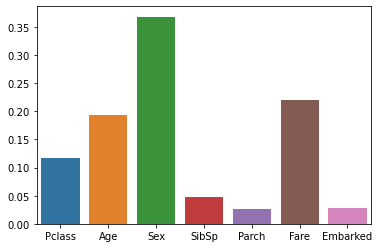

In [186]:
importances = pd.DataFrame(grid_search2.best_estimator_.feature_importances_)
importances = importances.T
importances.columns = X2.columns

sns.barplot(data=importances)

In [23]:
X3 = new_data[['Pclass','Sex','Fare', 'Age']].copy()
X3['Age'] = X3['Age'].fillna(X3.groupby('Sex')['Age'].transform('mean'))
y3 = new_data['Survived'].copy()

#Hyperparameter tuning part 3 - this time with only the top 4 most important featgures. Let's do less tuning this time to see if there's more variability
param_grids = {
    "n_estimators": [5, 20, 50, 100],
    "max_depth": [3, 5, 10, 20],
    "max_features": [3, 4],
}
grid_search3 = GridSearchCV(
    estimator=clf,
    param_grid=param_grids,
    cv=cv,
    ).fit(X3, y3)
results3 = pd.DataFrame(grid_search3.cv_results_)

In [189]:
grid_search3.best_estimator_

RandomForestClassifier(max_depth=10, max_features=4, n_estimators=50,
                       random_state=0)

In [190]:
# results are almost the same with only these four columns
results3.loc[results3['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
22,0.073892,0.003285,0.004651,0.000377,10,4,50,"{'max_depth': 10, 'max_features': 4, 'n_estima...",0.786517,0.797753,0.88764,0.865169,0.853933,0.752809,0.853933,0.831461,0.876404,0.784091,0.828971,0.043413,1


## More EDA

In [11]:
raw_data
#titles could be useful, cabins could be useful but are limited
#I'm suspecting interactions between Sex/Age, Sex/Parch, 
#I can't see a reasonable strategy for tickets seeing how many are just numbers, and I don't think they could really provide much more info than either embarked or price

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [13]:
# title extraction - NOTE: I tried this with one-hot encoding (and consolidating titles like Ms -> Mrs, but 
# performance was actually worse.)
title = []
i=0
for name in raw_data['Name']:
    i+=1
    parts = name.split('.')
    before_period = parts[0].strip()
    title.append(before_period.split(',')[-1])
titles = pd.DataFrame(title)
titles.rename(columns={titles.columns[0]: 'Title'}, inplace=True)

In [74]:
titles.value_counts()

Title        
 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Col               2
 Mlle              2
 Major             2
 Jonkheer          1
 Don               1
 the Countess      1
 Lady              1
 Sir               1
 Mme               1
 Ms                1
 Capt              1
dtype: int64

In [14]:
new_features = pd.DataFrame(titles)
le = LabelEncoder()
new_features['Title'] = le.fit_transform(new_features)
new_features

/Users/willthompson/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Title
0,11
1,12
2,8
3,12
4,11
...,...
886,14
887,8
888,8
889,11


<AxesSubplot:xlabel='Age', ylabel='Sex'>

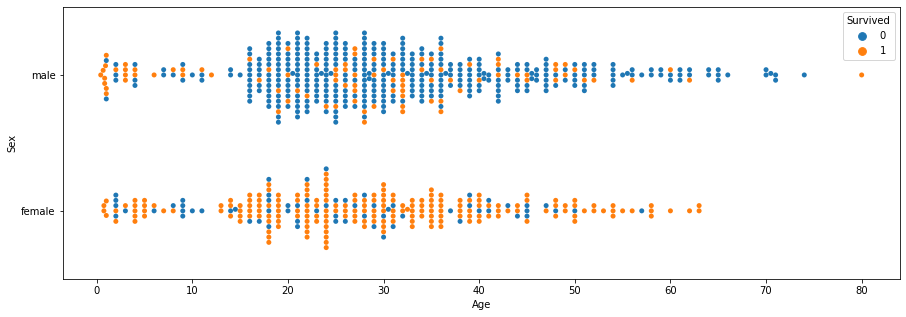

In [107]:
#Age seems more important in males
fix, ax = plt.subplots(figsize=(15,5))
sns.swarmplot(x=raw_data['Age'], y=raw_data['Sex'], hue=raw_data['Survived'])

/Users/willthompson/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/willthompson/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Parch', ylabel='Age'>

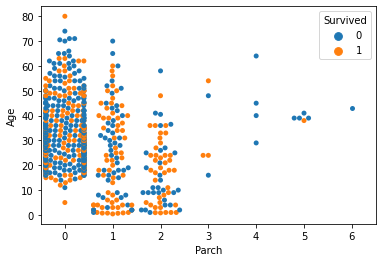

In [110]:
sns.swarmplot(x=raw_data['Parch'], y=raw_data['Age'], hue=raw_data['Survived'])

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

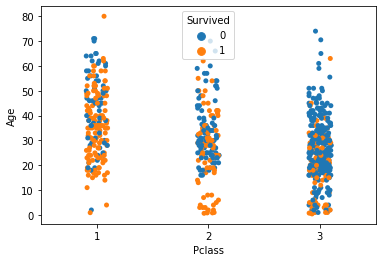

In [99]:
sns.stripplot(x=raw_data['Pclass'], y=raw_data['Age'], hue=raw_data['Survived'])
#young people in class 2 survived

<AxesSubplot:xlabel='Fare', ylabel='Embarked'>

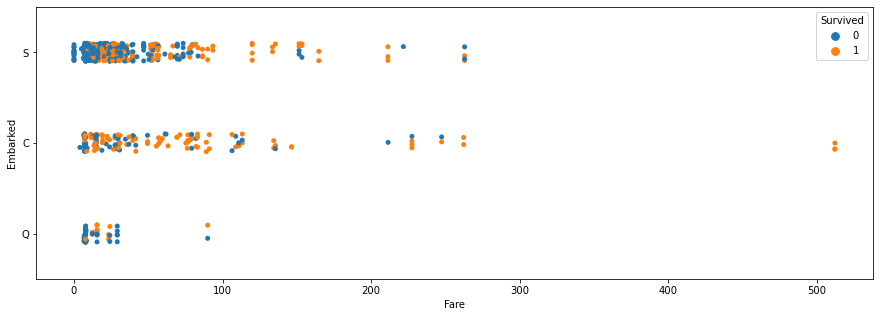

In [139]:
fix, ax = plt.subplots(figsize=(15,5))
sns.stripplot(x=raw_data['Fare'], y=raw_data['Embarked'], hue=raw_data['Survived'])

In [25]:
X5 = X3.copy()
X5['Title'] = new_features
y5 = y3.copy()
X5

,Pclass,Sex,Fare,Age,Title
0,3,1,7.2500,22.000000,11
1,1,0,71.2833,38.000000,12
2,3,0,7.9250,26.000000,8
3,1,0,53.1000,35.000000,12
4,3,1,8.0500,35.000000,11
...,...,...,...,...,...
886,2,1,13.0000,27.000000,14
887,1,0,30.0000,19.000000,8
888,3,0,23.4500,27.745174,8
889,1,1,30.0000,26.000000,11


In [191]:
#Hyperparameter tuning part 5 - this time with Title.
param_grids = {
    "n_estimators": [5, 20, 50, 100],
    "max_depth": [3, 5, 10, 20],
    "max_features": [3, 4, 5],
}
grid_search5 = GridSearchCV(
    estimator=clf,
    param_grid=param_grids,
    cv=cv,
    ).fit(X5, y5)
results5 = pd.DataFrame(grid_search5.cv_results_)

In [192]:
#Improvement!
results5.loc[results5['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
34,0.073541,0.001316,0.004415,0.000088,10,5,50,"{'max_depth': 10, 'max_features': 5, 'n_estima...",0.842697,0.876404,0.853933,0.910112,0.820225,0.797753,0.842697,0.764045,0.910112,0.840909,0.845889,0.043548,1


In [193]:
grid_search5.best_estimator_

RandomForestClassifier(max_depth=10, max_features=5, n_estimators=50,
                       random_state=0)

### I'm wondering if the continuous features are impacting the model's ability to fit either via outliers, skew, or adding too much noise. Random Forests are typically robust to these, but with a small data set and huge outliers, they could be doing something

In [143]:
X5['Age'].describe()

count    889.000000
mean      29.680279
std       12.982895
min        0.420000
25%       22.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

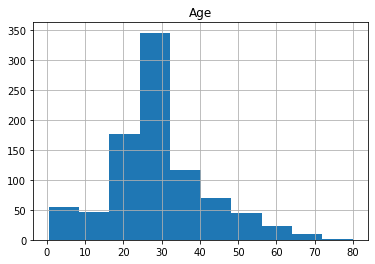

In [144]:
#since this looks pretty normal, I'm going to use quantile segmentation.
X5.hist(column='Age')

In [27]:
X6 = X5.copy()
y6 = y5.copy()

In [28]:
kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X6['Age'] = kbd.fit_transform(X6[['Age']])

/Users/willthompson/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [194]:
#Hyperparameter tuning part 6 - this time with age binning
param_grids = {
    "n_estimators": [5, 20, 50, 100],
    "max_depth": [3, 5, 10, 20],
    "max_features": [3, 4, 5],
}
grid_search6 = GridSearchCV(
    estimator=clf,
    param_grid=param_grids,
    cv=cv,
    ).fit(X6, y6)
results6 = pd.DataFrame(grid_search6.cv_results_)

In [195]:
#didn't necessarily help
results6.loc[results6['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
19,0.113327,0.002982,0.006984,0.000219,5,4,100,"{'max_depth': 5, 'max_features': 4, 'n_estimat...",0.853933,0.853933,0.842697,0.853933,0.820225,0.842697,0.786517,0.820225,0.820225,0.886364,0.838075,0.025967,1


In [196]:
grid_search6.best_estimator_

RandomForestClassifier(max_depth=5, max_features=4, random_state=0)

In [29]:
#lets look at fare
X7 = X5.copy()
y7 = y5.copy()

In [202]:
X5['Fare'].describe()

count    889.000000
mean      32.096681
std       49.697504
min        0.000000
25%        7.895800
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

array([[<AxesSubplot:title={'center':'Fare'}>]], dtype=object)

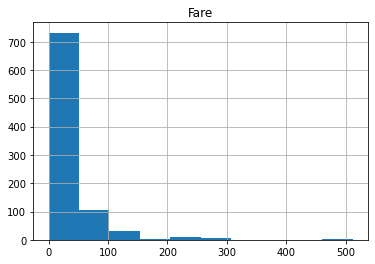

In [204]:
X5.hist(column='Fare')

In [30]:
#box-cox transformation to address left skew. First, we need to make 0 values non-0 first
X7.loc[X7['Fare'] == 0]
X7['Fare'].replace(0, .01, inplace=True)

#then, apply transformation
X7['Fare'] = power_transform(X7[['Fare']], method='box-cox')

In [240]:
#Hyperparameter tuning part 7 - this time with scaled fares
param_grids = {
    "n_estimators": [5, 20, 50, 100],
    "max_depth": [3, 5, 10, 20],
    "max_features": [3, 4, 5],
}
grid_search7 = GridSearchCV(
    estimator=clf,
    param_grid=param_grids,
    cv=cv,
    ).fit(X7, y7)
results7 = pd.DataFrame(grid_search7.cv_results_)

In [241]:
#didn't necessarily help
results7.loc[results7['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
31,0.146135,0.010468,0.008389,0.001617,10,4,100,"{'max_depth': 10, 'max_features': 4, 'n_estima...",0.865169,0.842697,0.820225,0.865169,0.842697,0.842697,0.820225,0.865169,0.842697,0.784091,0.839083,0.024143,1


In [242]:
grid_search7.best_estimator_

RandomForestClassifier(max_depth=10, max_features=4, random_state=0)

In [32]:
X8 = X6.copy()
y8 = y6.copy()
X8['Fare'] = X7['Fare']

In [221]:
#Hyperparameter tuning part 8 - trying both b/c why not
param_grids = {
    "n_estimators": [5, 20, 50, 100],
    "max_depth": [3, 5, 10, 20],
    "max_features": [3, 4, 5],
}
grid_search8 = GridSearchCV(
    estimator=clf,
    param_grid=param_grids,
    cv=cv,
    ).fit(X8, y8)
results8 = pd.DataFrame(grid_search8.cv_results_)

In [222]:
#potentially helped
results8.loc[results8['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
22,0.064366,0.00683,0.004616,0.000367,5,5,50,"{'max_depth': 5, 'max_features': 5, 'n_estimat...",0.876404,0.898876,0.820225,0.820225,0.865169,0.853933,0.831461,0.808989,0.820225,0.829545,0.842505,0.02806,1


In [223]:
grid_search8.best_estimator_

RandomForestClassifier(max_depth=5, max_features=5, n_estimators=50,
                       random_state=0)

In [33]:
# Last model I'm going to try: all (usable) features, but with scaled fare and titles.
X9 = X2.copy()
X9['Fare'] = X8['Fare']
X9['Title'] = X5['Title']
y9 = y8.copy()

In [237]:
#Hyperparameter tuning part 9 - final try
param_grids = {
    "n_estimators": [5, 20, 50, 100],
    "max_depth": [3, 5, 10, 20],
    "max_features": [3, 4, 5],
}
grid_search9 = GridSearchCV(
    estimator=clf,
    param_grid=param_grids,
    cv=cv,
    ).fit(X9, y9)
results9 = pd.DataFrame(grid_search9.cv_results_)

In [238]:
#potentially helped
results9.loc[results9['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
27,0.137849,0.006009,0.008451,0.001473,10,3,100,"{'max_depth': 10, 'max_features': 3, 'n_estima...",0.808989,0.876404,0.820225,0.865169,0.842697,0.865169,0.898876,0.797753,0.786517,0.818182,0.837998,0.035355,1


In [239]:
grid_search9.best_estimator_

RandomForestClassifier(max_depth=10, max_features=3, random_state=0)

In conclusion, model 5 worked the best. This model contained Pclass, Sex, Fare, Age, and Title. I think this makes sense, for the following reasons:\
Passenger ID = N/A\
Pclass (used) = Probably influences location on the boat - or how much they are attended to.\
Name (used) = Title extraction ended up being helpful. I can see status impacting who is first to be saved.\
Sex (used) = Undeniably most important. This is verified via EDA, but also is a well-known fact ("women and children")\
Age (used) = Similar to sex - "women and children".\
SibSp (dropped) = This didn't improve accuracy in any situation - probably just adds noise to Age and Sex\
Parch (dropped) = Similar to SibSp - probably just added noise.\
Ticket (dropped) = I really just couldn't see a useful extraction here if Embarked was useless.\
Fare (used) = Also probably influences location on boat or how much they are attended to.\
Cabin (dropped) = Too many null values for such a small training set.\
Embarked (dropped) = I can only see this adding noise when Fare and Pclass are usefull. Logically it wouldn't help.

## Prepare Test Set

In [35]:
test_data = pd.read_csv("test.csv", header = 0, encoding ='utf-8')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


<AxesSubplot:>

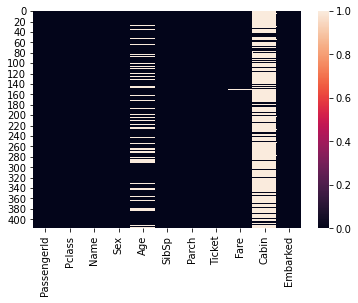

In [448]:
sns.heatmap(test_data.isnull())

In [36]:
#We'll have to impute one value for fare, impute age values, then do title extraction.
X_test = test_data[['Pclass', 'Name', 'Sex', 'Age', 'Fare']].copy()
X_test['Sex'].replace('female', 0, inplace=True)
X_test['Sex'].replace('male', 1, inplace=True)
X_test

,Pclass,Name,Sex,Age,Fare
0,3,"Kelly, Mr. James",1,34.5,7.8292
1,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,7.0000
2,2,"Myles, Mr. Thomas Francis",1,62.0,9.6875
3,3,"Wirz, Mr. Albert",1,27.0,8.6625
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,12.2875
...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",1,NaN,8.0500
414,1,"Oliva y Ocana, Dona. Fermina",0,39.0,108.9000
415,3,"Saether, Mr. Simon Sivertsen",1,38.5,7.2500
416,3,"Ware, Mr. Frederick",1,NaN,8.0500


In [450]:
titles.value_counts()

Title        
 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Col               2
 Mlle              2
 Major             2
 Jonkheer          1
 Don               1
 the Countess      1
 Lady              1
 Sir               1
 Mme               1
 Ms                1
 Capt              1
dtype: int64

In [38]:
#title extraction
test_title = []
i=0
for name in X_test['Name']:
    i+=1
    parts = name.split('.')
    before_period = parts[0].strip()
    test_title.append(before_period.split(',')[-1])
test_titles = pd.DataFrame(test_title)
test_titles.rename(columns={test_titles.columns[0]: 'Title'}, inplace=True)

In [39]:
test_titles.value_counts()

Title  
 Mr        240
 Miss       78
 Mrs        72
 Master     21
 Rev         2
 Col         2
 Ms          1
 Dr          1
 Dona        1
dtype: int64

In [40]:
test_titles

,Title
0,Mr
1,Mrs
2,Mr
3,Mr
4,Mrs
...,...
413,Mr
414,Dona
415,Mr
416,Mr


In [42]:
#Dona means Mrs or Madam in spanish. Lets just change it to Mrs in the test set.
X_test[X_test['Name'].str.contains("Dona")]

,Pclass,Name,Sex,Age,Fare
239,1,"Douglas, Mrs. Walter Donald (Mahala Dutton)",0,48.0,106.425
414,1,"Oliva y Ocana, Dona. Fermina",0,39.0,108.900


In [43]:
X_test['Title'] = test_titles
X_test['Title'].replace(' Dona', ' Mrs', inplace=True)

In [44]:
X_test

,Pclass,Name,Sex,Age,Fare,Title
0,3,"Kelly, Mr. James",1,34.5,7.8292,Mr
1,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,7.0000,Mrs
2,2,"Myles, Mr. Thomas Francis",1,62.0,9.6875,Mr
3,3,"Wirz, Mr. Albert",1,27.0,8.6625,Mr
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,12.2875,Mrs
...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",1,NaN,8.0500,Mr
414,1,"Oliva y Ocana, Dona. Fermina",0,39.0,108.9000,Mrs
415,3,"Saether, Mr. Simon Sivertsen",1,38.5,7.2500,Mr
416,3,"Ware, Mr. Frederick",1,NaN,8.0500,Mr


In [457]:
#hardcoding to ensure labeling is consistent
title_mapping = {
    ' Mr': 11,
    ' Miss': 8,
    ' Mrs': 12,
    ' Master': 7,
    ' Rev': 14,
    ' Col': 1,
    ' Ms': 13,
    ' Dr': 3
}
X_test['Title'].replace(title_mapping, inplace=True)
X_test.drop(['Name'], axis=1, inplace=True)

In [458]:
#impute age
X_test['Age'] = np.where((X_test['Age'].isnull()) & (X_test['Sex'] == 1), 30.726645, X_test['Age'])
X_test['Age'] = np.where((X_test['Age'].isnull()) & (X_test['Sex'] == 0), 27.745174, X_test['Age'])

In [459]:
#impute fare (using training set avg fare)
fare_imp =  new_data['Fare'].mean()
X_test['Fare'].fillna(fare_imp, inplace=True)

In [45]:
# Rearrange
X_test = X_test[['Pclass','Sex', 'Fare', 'Age', 'Title']]

## Fit and Predict

In [360]:
#Build classifier and make predictions
grid_search5.best_estimator_

RandomForestClassifier(max_depth=10, max_features=5, n_estimators=50,
                       random_state=0)

In [462]:
clf_test = RandomForestClassifier(max_depth=10, max_features=5, n_estimators=50)
clf_test.fit(X5,y5)
y_pred = clf_test.predict(X_test)

In [2]:
predictions_df = pd.DataFrame(y_pred)

In [46]:
submission = test_data[['PassengerId']]
submission['Survived'] = predictions_df

In [466]:
submission.to_csv('/Users/willthompson/Documents/TitanicSubmission/gender_submission3.csv', index=False)

# Result: ~78% Accuracy